# Chronic Kidney Disease (CKD) Diagnostic Pipeline
**Student Name:** Youssef Ahmed Mohamed Awad 

**Student ID:** 1210168

In [ ]:
# Run if there is a library Problem
#%pip install -t requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Target path exists but is not a directory, will not continue.


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.impute import KNNImputer
from torch import dropout

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Task 1: Data Pipeline
**Instructions:**
1. Load the `kidney_disease.csv` file.
2. Drop all categorical (string) columns to isolate the numerical lab values.
3. Handle missing values (`NaN`s).
4. Scale the features to prevent data leakage.
5. Perform an 80/20 train/validation split.

In [67]:
# Write your Data Pipeline code here
df= pd.read_csv(r'data/kidney_disease.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [68]:
#removing all catagorical data except the target variable
cols_to_drop = [c for c in df.select_dtypes(include='object').columns if c != 'classification']
df = df.drop(columns=cols_to_drop)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   bgr             356 non-null    float64
 7   bu              381 non-null    float64
 8   sc              383 non-null    float64
 9   sod             313 non-null    float64
 10  pot             312 non-null    float64
 11  hemo            348 non-null    float64
 12  classification  400 non-null    object 
dtypes: float64(11), int64(1), object(1)
memory usage: 40.8+ KB


In [69]:
#Label Encoder
df['classification'] = (df['classification'].str.strip() == 'ckd').astype(int)
# ckd → 1, notckd → 0

In [70]:
null_ratio=df.isnull().any(axis=1).sum()/len(df)*100
if null_ratio > 20:
    print("Too many null values in rows. cannot drop them.")
    print("applying KNN imputation to fill the null values.")
    imputer = KNNImputer(n_neighbors=5)
    feature_cols = [c for c in df.columns if c != 'classification']
    df[feature_cols] = imputer.fit_transform(df[feature_cols])    
else:
    print("Null ratio is acceptable.")
    # Drop rows with null values
    df = df.dropna()

Too many null values in rows. cannot drop them.
applying KNN imputation to fill the null values.


In [71]:
#scaling step
x=df[feature_cols]
y= df['classification']

X_train,X_test,Y_train,Y_test=train_test_split(
    x,
    y,
    train_size=0.8,
    random_state=42,
    stratify=y,
    )


In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n─── Split Sizes ─────────────────────────────────")
print(f"Training set    : {X_train_scaled.shape}")
print(f"Test set        : {X_test_scaled.shape}")


─── Split Sizes ─────────────────────────────────
Training set    : (320, 12)
Test set        : (80, 12)


## Task 2: The Engineered Failure (Baseline Model)
**Instructions:** Build and train an unregularised Dense network. Plot the training and validation loss curves to visually prove it overfits.

In [73]:
# Write your Baseline Model code here - intentionally overparameterised to provoke overfitting
model_A = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dense(64, activation="relu"),   # oversized for dataset size
        tf.keras.layers.Dense(64, activation="relu"),   # no regularisation
        tf.keras.layers.Dense(32, activation="relu"),   # excess capacity → memorisation
        tf.keras.layers.Dense(1,   activation="sigmoid"),
    ],
    name="Model_A_Baseline",
)

model_A.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # aggressive LR
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Recall(name="recall")],
)

model_A.summary()

Model: "Model_A_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,105 (27.75 KB)

 Trainable params: 7,105 (27.75 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
model_A_history = model_A.fit(
    X_train_scaled,
    Y_train,
    validation_data=(X_test_scaled, Y_test),
    epochs=100,  # excessive epochs to encourage overfitting
    batch_size=16,  # small batch size for noisier updates
    verbose=1,
)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6375 - loss: 0.5884 - recall: 0.4200 - val_accuracy: 0.9000 - val_loss: 0.4688 - val_recall: 0.8400
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9781 - loss: 0.3283 - recall: 0.9650 - val_accuracy: 0.9875 - val_loss: 0.2096 - val_recall: 0.9800
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9937 - loss: 0.1301 - recall: 0.9900 - val_accuracy: 0.9875 - val_loss: 0.0723 - val_recall: 0.9800
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9969 - loss: 0.0464 - recall: 0.9950 - val_accuracy: 0.9875 - val_loss: 0.0346 - val_recall: 0.9800
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9969 - loss: 0.0238 - recall: 0.9950 - val_accuracy: 0.9875 - val_loss: 0.0244 - val_recall: 0.9800
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9969 - loss: 0.0159 - recall: 0.9950 - val_accuracy: 0.9875 - val_loss: 0.0202 - val_recall: 0.9800
Epoch 7/1

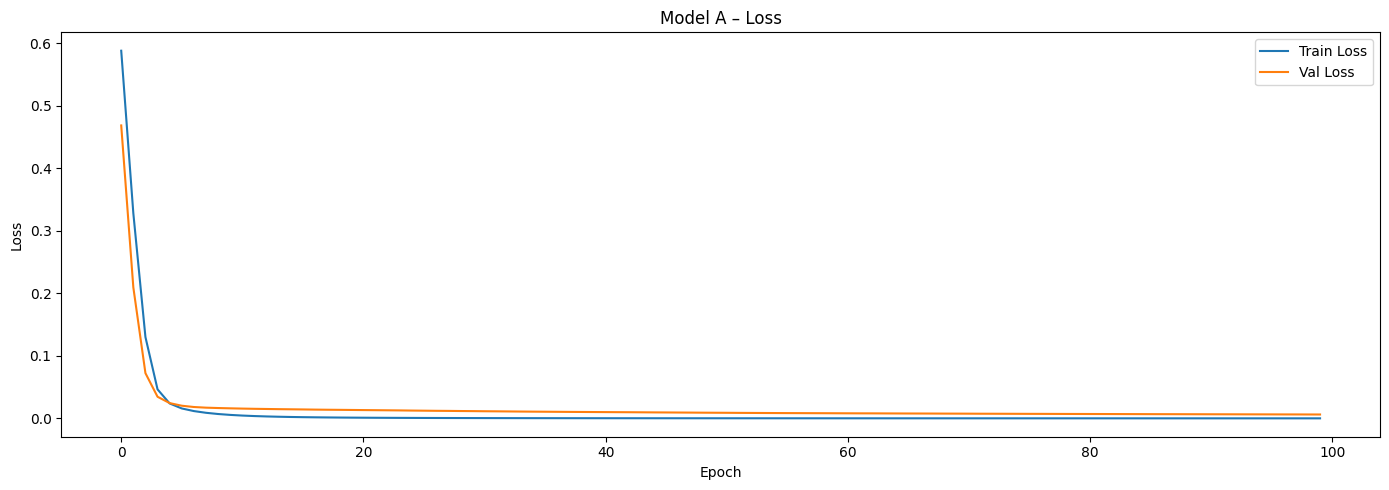

In [75]:
# Plot training history for Model A
fig, axes = plt.subplots(1, 1, figsize=(14, 5))

# Loss
axes.plot(model_A_history.history['loss'],     label='Train Loss')
axes.plot(model_A_history.history['val_loss'], label='Val Loss')
axes.set_title('Model A – Loss')
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')
axes.legend()

plt.tight_layout()
plt.show()

## Task 3: The Clinical Solution (Engineered Model)
**Instructions:** Build a second model using regularisation techniques (e.g., L2, Dropout, LeakyReLU). Train it and plot the curves to demonstrate the reduction in overfitting.

In [109]:
# Write your Engineered Model code here


l2 = tf.keras.regularizers.l2

model_B = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dense(64, kernel_regularizer=l2(0.001)),
        tf.keras.layers.LeakyReLU(alpha=0.01),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(32, kernel_regularizer=l2(0.001)),
        tf.keras.layers.LeakyReLU(alpha=0.01),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ],
    name="Model_B_Regularised",
)

model_B.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Recall(name="recall")],
)

model_B.summary()

Model: "Model_B_Regularised"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_53 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

lron_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)



model_B_history = model_B.fit(
    X_train_scaled,
    Y_train,
    validation_data=(X_test_scaled, Y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, lron_plateau],
    verbose=1,
)



Epoch 1/100


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4594 - loss: 0.9014 - recall: 0.5050 - val_accuracy: 0.2250 - val_loss: 1.0250 - val_recall: 0.3600 - learning_rate: 1.0000e-04
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4781 - loss: 0.8393 - recall: 0.5800 - val_accuracy: 0.2500 - val_loss: 0.9742 - val_recall: 0.3800 - learning_rate: 1.0000e-04
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5219 - loss: 0.8103 - recall: 0.6150 - val_accuracy: 0.2875 - val_loss: 0.9295 - val_recall: 0.4400 - learning_rate: 1.0000e-04
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5625 - loss: 0.7967 - recall: 0.6250 - val_accuracy: 0.3625 - val_loss: 0.8842 - val_recall: 0.5200 - learning_rate: 1.0000e-04
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5594 - loss: 0.7752 - recall: 0.6500 - val_accuracy: 0.4500 - val_loss: 0.8416 - val_recall: 0.6200 - learning_rate: 1.0000e-04
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

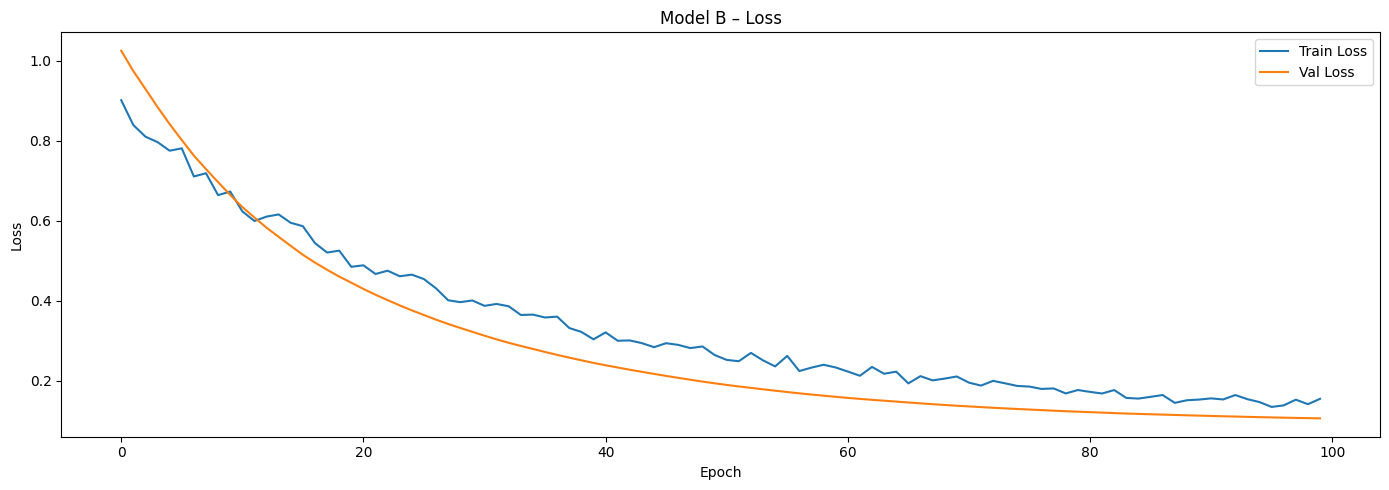

In [111]:
# Plot training history for Model B
fig, axes = plt.subplots(1, 1, figsize=(14, 5))

# Training Loss
axes.plot(model_B_history.history['loss'],     label='Train Loss')
axes.plot(model_B_history.history['val_loss'], label='Val Loss')
axes.set_title('Model B – Loss')
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')
axes.legend()

plt.tight_layout()
plt.show()

## Task 4: Evaluation & Mathematical Justification
**Instructions:**
1. Render the confusion matrices for both models.
2. Print the final validation Recall for both models.
3. Answer the justification question below.

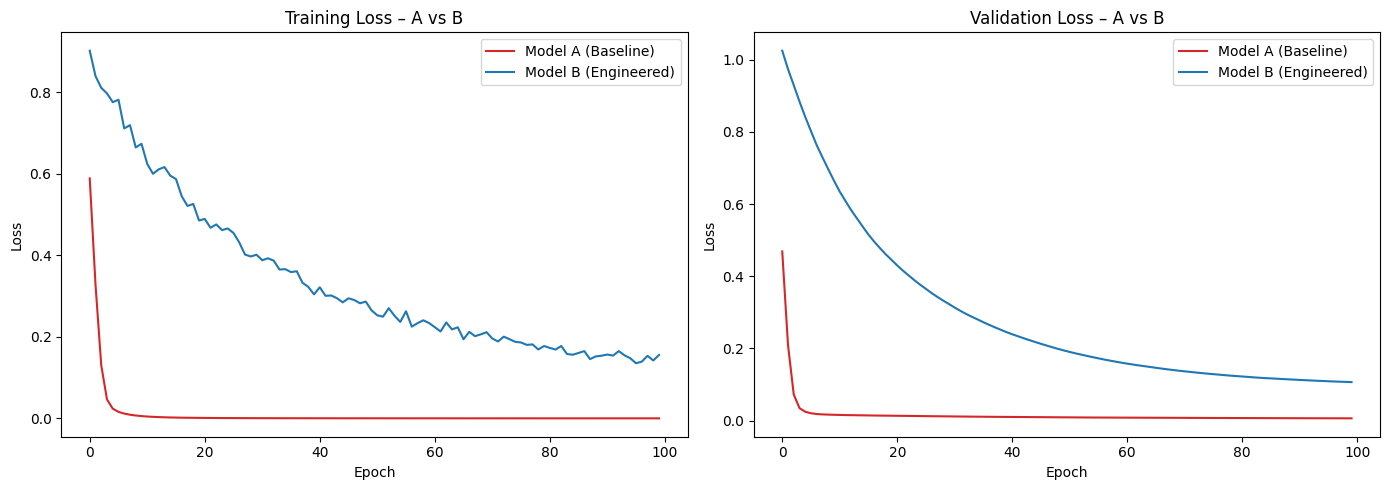

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


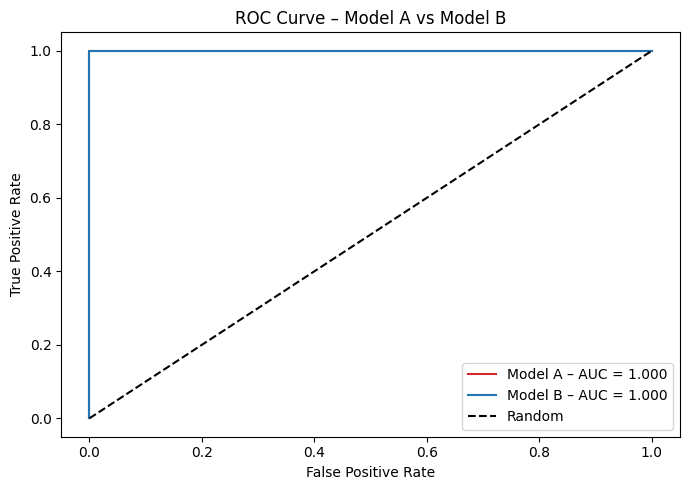

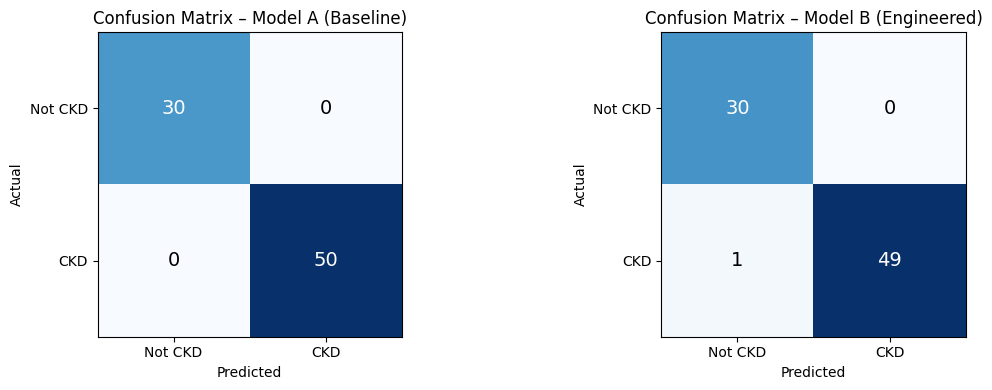

Model A – Validation Recall : 1.0000
Model B – Validation Recall : 0.9800


In [112]:
# ── 1. Loss Comparison: Training & Validation ────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Training Loss
axes[0].plot(model_A_history.history['loss'], label='Model A (Baseline)', color='tab:red')
axes[0].plot(model_B_history.history['loss'], label='Model B (Engineered)', color='tab:blue')
axes[0].set_title('Training Loss – A vs B')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot Validation Loss
axes[1].plot(model_A_history.history['val_loss'], label='Model A (Baseline)', color='tab:red')
axes[1].plot(model_B_history.history['val_loss'], label='Model B (Engineered)', color='tab:blue')
axes[1].set_title('Validation Loss – A vs B')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

# ── 2. ROC Curves & AUC ───────────────────────────────────────────────────────
prob_A = model_A.predict(X_test_scaled).ravel()
prob_B = model_B.predict(X_test_scaled).ravel()

fpr_A, tpr_A, _ = roc_curve(Y_test, prob_A)
fpr_B, tpr_B, _ = roc_curve(Y_test, prob_B)
auc_A = auc(fpr_A, tpr_A)
auc_B = auc(fpr_B, tpr_B)

plt.figure(figsize=(7, 5))
plt.plot(fpr_A, tpr_A, label=f'Model A – AUC = {auc_A:.3f}', color='tab:red')
plt.plot(fpr_B, tpr_B, label=f'Model B – AUC = {auc_B:.3f}', color='tab:blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Model A vs Model B')
plt.legend()
plt.tight_layout()
plt.show()

# ── 3. Confusion Matrices ─────────────────────────────────────────────────────
pred_A = (prob_A >= 0.5).astype(int)
pred_B = (prob_B >= 0.5).astype(int)
cm_A = confusion_matrix(Y_test, pred_A)
cm_B = confusion_matrix(Y_test, pred_B)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, cm, title in zip(axes, [cm_A, cm_B], ['Model A (Baseline)', 'Model B (Engineered)']):
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(f'Confusion Matrix – {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Not CKD', 'CKD'])
    ax.set_yticklabels(['Not CKD', 'CKD'])
    
    # Add text annotations inside the matrix
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center',
                    color='white' if cm[i, j] > cm.max() / 2 else 'black', 
                    fontsize=14)

plt.tight_layout()
plt.show()

# ── 4. Final Validation Recall ────────────────────────────────────────────────
recall_A = recall_score(Y_test, pred_A)
recall_B = recall_score(Y_test, pred_B)

print(f'Model A – Validation Recall : {recall_A:.4f}')
print(f'Model B – Validation Recall : {recall_B:.4f}')

### Mathematical Justification
**Final Parameter Count of Engineered Model:** [2,945]

**Explanation:** With only 2,945 parameters across 320 training samples, L2 regularisation shrinks large weights toward zero by penalising 
λ∥w∥^2
 , while Dropout prevents co-adaptation between neurons, together constraining the hypothesis space to smooth generalisable decision boundaries rather than memorised training patterns.